In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, gridspec
import ipywidgets as widgets
import glob
from IPython.display import display, clear_output

# 可视化设置
rcParams['font.family'] = 'SimHei'
rcParams['axes.unicode_minus'] = False

class ModisVisualizer:
    BAND_INFO = {
        'ENTIRE': {'bands': 7, 'bins': 32, 'range': (1, 8000)},
        'EVI': {'bands': 1, 'bins': 32, 'range': (-1, 1)},
        'FPAR': {'bands': 1, 'bins': 32, 'range': (1, 75)},
        'LAI': {'bands': 1, 'bins': 32, 'range': (0, 15)},
        'NDMI': {'bands': 1, 'bins': 32, 'range': (-1, 1)},
        'NDVI': {'bands': 1, 'bins': 32, 'range': (-1, 1)},
        'Temperature': {'bands': 2, 'bins': 32, 'range': (-50, 50)},
        'SIPI': {'bands': 1, 'bins': 32, 'range': (0, 2)},
        'GNDVI': {'bands': 1, 'bins': 32, 'range': (-1, 1)}
    }

    # 自定义波段描述信息
    BAND_DESCRIPTIONS = {
        1: "620-670nm(红光波段)",
        2: "841-876nm(近红外波段)",
        3: "459-479nm(蓝光波段)",
        4: "545-565nm(绿光波段)",
        5: "1230-1250nm(短红外波段)",
        6: "1628-1652nm(中红外波段1)",
        7: "2105-2155nm(中红外波段2)",
        8: "EVI(增强型植被指数)",
        9: "FPAR(光合有效辐射吸收比例)",
        10: "LAI(叶面积指数)",
        11: "NDMI(归一化水分指数)",
        12: "NDVI(归一化植被指数)",
        13: "LST of day(地表日间温度)",
        14: "LST of night(地表夜间温度)",
        15: "SIPI(结构不敏感色素指数)",
        16: "GNDVI(绿光归一化植被指数)"
    }

    def __init__(self, processed_dir):
        self.processed_dir = processed_dir
        self.all_files = glob.glob(os.path.join(processed_dir, "*_*_*_all.npz"))
        self.current_plot = None
        self.setup_ui()
        
    def parse_filename(self, filename):
        """解析文件名获取省、市、年份信息"""
        basename = os.path.basename(filename)
        parts = basename.split('_')
        if len(parts) >= 4:
            return parts[0], parts[1], parts[2]
        return None, None, None
    
    def get_unique_values(self):
        """获取所有文件中唯一的省、市、年份"""
        provinces, cities, years = set(), set(), set()
        for f in self.all_files:
            p, c, y = self.parse_filename(f)
            if p:
                provinces.add(p)
                cities.add(c)
                years.add(y)
        return sorted(provinces), sorted(cities), sorted(years)
    
    def setup_ui(self):
        """设置交互式UI组件"""
        provinces, cities, years = self.get_unique_values()
        
        # 创建下拉菜单
        self.province_dropdown = widgets.Dropdown(
            options=provinces,
            description='省级码:',
            style={'description_width': 'initial'}
        )
        
        self.city_dropdown = widgets.Dropdown(
            options=cities,
            description='区位码:',
            style={'description_width': 'initial'}
        )
        
        self.year_dropdown = widgets.Dropdown(
            options=years,
            description='年份:',
            style={'description_width': 'initial'}
        )
        
        # 创建按钮
        self.plot_button = widgets.Button(
            description='生成可视化',
            button_style='success',
            layout=widgets.Layout(width='200px')
        )
        self.plot_button.on_click(self.on_plot_clicked)
        
        # 添加清除按钮
        self.clear_button = widgets.Button(
            description='清除图像',
            button_style='warning',
            layout=widgets.Layout(width='200px')
        )
        self.clear_button.on_click(self.on_clear_clicked)
        
        # 显示UI组件
        display(widgets.VBox([
            self.province_dropdown,
            self.city_dropdown,
            self.year_dropdown,
            widgets.HBox([self.plot_button, self.clear_button])
        ]))
    
    def on_plot_clicked(self, b):
        """可视化回调函数"""
        plt.close('all')
        clear_output(wait=True)
        
        # 重新显示UI组件
        display(widgets.VBox([
            self.province_dropdown,
            self.city_dropdown,
            self.year_dropdown,
            widgets.HBox([self.plot_button, self.clear_button])
        ]))
        
        province = self.province_dropdown.value
        city = self.city_dropdown.value
        year = self.year_dropdown.value
        
        pattern = f"{province}_{city}_{year}_all.npz"
        matching_files = glob.glob(os.path.join(self.processed_dir, pattern))
        
        if not matching_files:
            print(f"未找到匹配文件: {pattern}")
            return    
        
        self.visualize_all_bands(matching_files[0])
    
    def on_clear_clicked(self, b):
        """清除图像回调函数"""
        plt.close('all')
        clear_output(wait=True)
        
        # 重新显示UI组件
        display(widgets.VBox([
            self.province_dropdown,
            self.city_dropdown,
            self.year_dropdown,
            widgets.HBox([self.plot_button, self.clear_button])
        ]))
    
    def visualize_all_bands(self, filepath):
        """专业级波段可视化(时间步为X轴，BIN为Y轴的矩阵图)"""
        try:
            data = np.load(filepath)
            
            # 创建4x4子图网格，留出右侧空间放颜色条
            fig = plt.figure(figsize=(20, 20), dpi=100)
            self.current_plot = fig
            gs = gridspec.GridSpec(4, 4, wspace=0.3, hspace=0.4, right=0.85)  # 调整right参数留出颜色条空间
            
            # 波段计数器
            band_counter = 1  # 从1开始计数
            img_list = []  # 存储所有imshow对象，用于统一颜色条
            
            # 按BAND_INFO顺序处理每个指标
            for indicator in self.BAND_INFO.keys():
                if indicator not in data:
                    continue
                    
                features = data[indicator]  # (time, bands, bins)
                n_bands = features.shape[1]  # 该指标的波段数
                
                # 绘制该指标的所有波段
                for band_idx in range(n_bands):
                    ax = plt.subplot(gs[(band_counter-1)//4, (band_counter-1)%4])
                    
                    # 转置特征矩阵：时间步为X轴(16)，BIN为Y轴(32)
                    band_data = features[:, band_idx, :].T  # 转置后变为(32 bins, 16 time)
                    
                    # 绘制矩阵图，颜色从黑到白表示值大小
                    img = ax.imshow(band_data, cmap='gray', aspect='auto', 
                                interpolation='none', origin='lower')
                    img_list.append(img)  # 添加到列表
                    
                    # 设置坐标轴标签
                    ax.set_xlabel('时间步 (1-16)', fontsize=10)
                    ax.set_ylabel('BIN区间 (1-32)', fontsize=10)
                    
                    # 设置刻度
                    ax.set_xticks(np.arange(0, 16, 3))
                    ax.set_xticklabels(np.arange(1, 17, 3))
                    ax.set_yticks(np.arange(0, 32, 5))
                    ax.set_yticklabels(np.arange(1, 33, 5))
                    
                    # 设置子图标题为 BandX(自定义描述)
                    band_desc = self.BAND_DESCRIPTIONS.get(band_counter, "")
                    ax.set_title(f"Band{band_counter}: {band_desc}", fontsize=10, pad=5)
                    
                    band_counter += 1
                    # 超过16个波段则停止
                    if band_counter > 16:
                        break
                
                if band_counter > 16:
                    break
            
            # 在右侧添加全局颜色条
            if img_list:
                cax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # 颜色条位置[left, bottom, width, height]
                cbar = fig.colorbar(img_list[0], cax=cax, orientation='vertical')
                
                # 移除刻度线并添加描述文本
                cbar.set_ticks([])
                cbar.set_label('值相对大小', rotation=270, labelpad=20, fontsize=14)
                # 在颜色条顶部和底部添加文字标注（可选）
                cbar.ax.text(0.5, 1.01, '高', 
                            ha='center', va='bottom', 
                            transform=cbar.ax.transAxes,
                            fontsize=18,  # 调大字体
                            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1))  # 添加白色背景提升可读性
                cbar.ax.text(0.5, -0.01, '低', 
                            ha='center', va='top', 
                            transform=cbar.ax.transAxes,
                            fontsize=18,  # 调大字体
                            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1))
                # # 可选：在颜色条中间添加方向箭头
                # cbar.ax.arrow(0.5, 0.5, 0, 0.4, 
                #             head_width=0.3, head_length=0.05, 
                #             fc='k', ec='k', transform=cbar.ax.transAxes)
            # 主标题
            plt.suptitle(
                f"MODIS波段时空特征矩阵 - {os.path.basename(filepath)}",
                y=0.92,
                fontsize=14,
                fontweight='bold'
            )
            
            plt.tight_layout(rect=[0, 0, 0.85, 1])  # 调整tight_layout范围，避开颜色条区域
            plt.show()
            
            # 打印数据信息
            print("="*60)
            print(f"文件: {os.path.basename(filepath)}")
            print(f"包含指标: {list(data.keys())}")
            print(f"总波段数: {band_counter-1}")
            print("="*60)
            
        except Exception as e:
            print(f"可视化错误: {str(e)}")



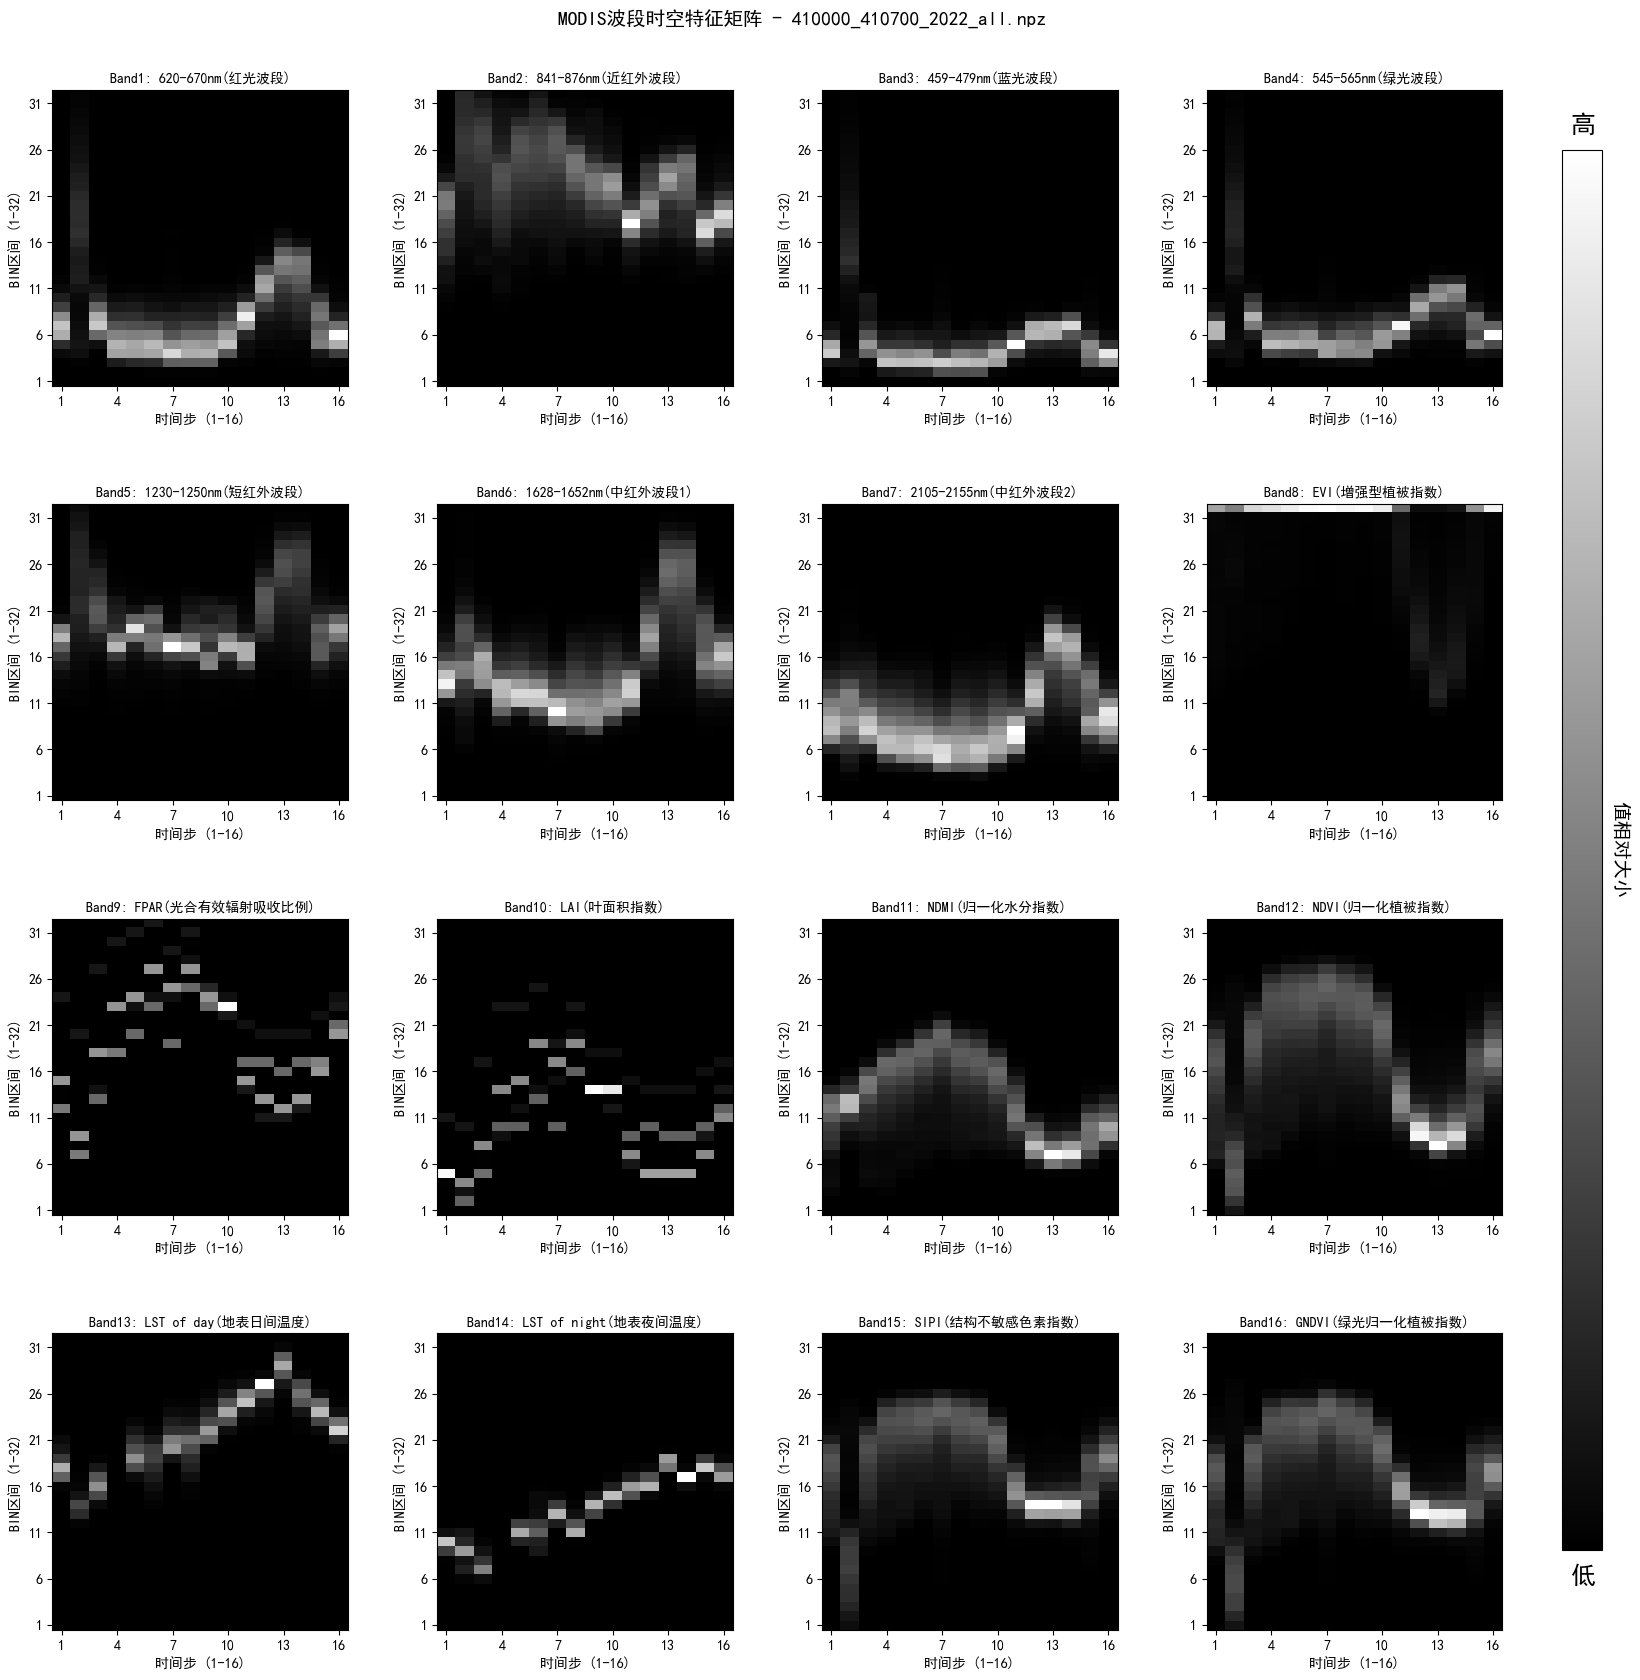

In [3]:
# visualizer = ModisVisualizer(r"D:\Crop\NorthChina\processed_32")
visualizer = ModisVisualizer(r"D:\Crop\NorthChina\processed_32")